In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
df = pd.read_csv('intermittent-renewables-production-france.csv')

In [3]:
df.head()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59806 entries, 0 to 59805
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date and Hour  59806 non-null  object 
 1   Date           59806 non-null  object 
 2   StartHour      59806 non-null  object 
 3   EndHour        59806 non-null  object 
 4   Source         59806 non-null  object 
 5   Production     59804 non-null  float64
 6   dayOfYear      59806 non-null  int64  
 7   dayName        59806 non-null  object 
 8   monthName      59806 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.1+ MB


In [5]:
forDrop = ['Date','StartHour','EndHour']
df.drop(forDrop,axis=1, inplace=True)

## Preparando os dados

In [6]:
from dateutil import parser

def extract_timezone_offset(datetime_string):
    # Parse the datetime string into a datetime object using dateutil.parser
    dt_object = parser.parse(datetime_string)
    
    # Extract the timezone offset from the datetime object in minutes
    offset_minutes = dt_object.utcoffset().total_seconds() // 60
    
    return int(offset_minutes)


In [7]:
def formatarData(data):
    if isinstance(data, datetime):
        data_string = data.strftime('%Y-%m-%d %H:%M:%S')
        partes = data_string.split('+')
        data_sem_timezone = partes[0]
        return data_sem_timezone
    else:
        return data

In [8]:
df['TimeZone'] = df['Date and Hour'].map(extract_timezone_offset)
df['Date and Hour'].map(formatarData)

0        2020-07-22 20:00:00+02:00
1        2020-07-23 07:00:00+02:00
2        2020-07-23 16:00:00+02:00
3        2020-07-23 19:00:00+02:00
4        2020-07-23 23:00:00+02:00
                   ...            
59801    2023-06-30 06:00:00+02:00
59802    2023-06-30 13:00:00+02:00
59803    2023-06-30 14:00:00+02:00
59804    2023-06-30 16:00:00+02:00
59805    2023-06-30 18:00:00+02:00
Name: Date and Hour, Length: 59806, dtype: object

In [9]:
unique_values = df['TimeZone'].unique()

# Create a mapping dictionary
mapping_dict = {unique_values[0]: 2, unique_values[1]: 1}

# Replace values in the 'Timezone_Offset' column using the mapping dictionary
df['TimeZone'] = df['TimeZone'].replace(mapping_dict)


In [10]:
df['Date and Hour'] = pd.to_datetime(df['Date and Hour'], utc=True)

# Removendo o fuso horário usando o método dt.tz_convert() e o argumento 'UTC'
df['Date and Hour'] = df['Date and Hour'].dt.tz_convert(None)


In [11]:
df.head()

,Date and Hour,Source,Production,dayOfYear,dayName,monthName,TimeZone
0,2020-07-22 18:00:00,Solar,244.0,204,Wednesday,July,2
1,2020-07-23 05:00:00,Solar,223.0,205,Thursday,July,2
2,2020-07-23 14:00:00,Solar,2517.0,205,Thursday,July,2
3,2020-07-23 17:00:00,Solar,658.0,205,Thursday,July,2
4,2020-07-23 21:00:00,Solar,0.0,205,Thursday,July,2


In [12]:
def createFeatures(df):
    df = df.copy()
    df['hour'] = df['Date and Hour'].dt.hour
    df['dayofweek'] = df['Date and Hour'].dt.dayofweek
    df['quarter'] = df['Date and Hour'].dt.quarter
    df['month'] = df['Date and Hour'].dt.month
    df['year'] = df['Date and Hour'].dt.year
    df['dayofyear'] = df['Date and Hour'].dt.dayofyear
    df['dayofmonth'] = df['Date and Hour'].dt.day
    df['weekofyear'] = df['Date and Hour'].dt.isocalendar().week
    return df

# Chama a função para criar as features
df = createFeatures(df)

In [13]:
df.head()

,Date and Hour,Source,Production,dayOfYear,dayName,monthName,TimeZone,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2020-07-22 18:00:00,Solar,244.0,204,Wednesday,July,2,18,2,3,7,2020,204,22,30
1,2020-07-23 05:00:00,Solar,223.0,205,Thursday,July,2,5,3,3,7,2020,205,23,30
2,2020-07-23 14:00:00,Solar,2517.0,205,Thursday,July,2,14,3,3,7,2020,205,23,30
3,2020-07-23 17:00:00,Solar,658.0,205,Thursday,July,2,17,3,3,7,2020,205,23,30
4,2020-07-23 21:00:00,Solar,0.0,205,Thursday,July,2,21,3,3,7,2020,205,23,30


## Setando o tipo de fonte a ser analisada

In [14]:
df = df.loc[df['Source'] == 'Solar']

## Train/Test split

In [15]:
df['Production'].fillna(df['Production'].mean(),inplace=True)

<Axes: xlabel='Date and Hour'>

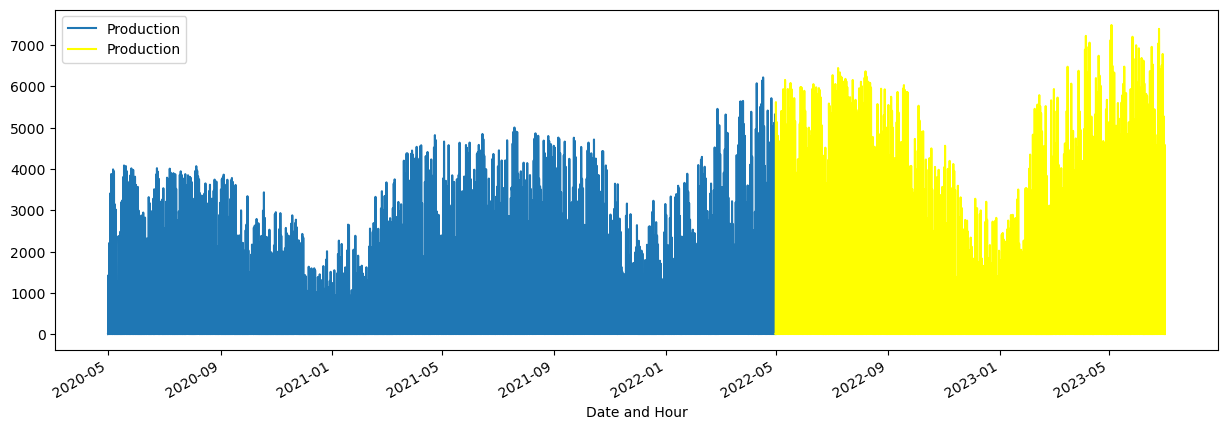

In [16]:
train = df.loc[(df['Date and Hour'] <= '2022-05') & (df['Date and Hour'] >= '2020-05')]
test = df.loc[df['Date and Hour']>'2022-05']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,x='Date and Hour',y='Production')
test.plot(ax=ax,x='Date and Hour',y='Production', color='yellow')

In [17]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

/tmp/ipykernel_24305/823325658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop_duplicates(inplace=True)
/tmp/ipykernel_24305/823325658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop_duplicates(inplace=True)


<Axes: xlabel='Date and Hour'>

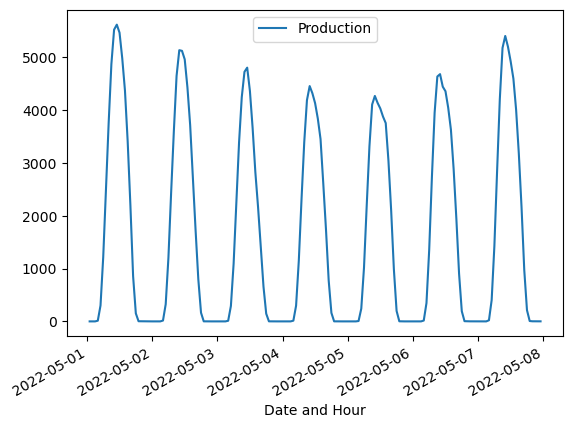

In [18]:
df.loc[(df['Date and Hour'] > '2022-05-01') & (df['Date and Hour'] < '2022-05-08')].plot(x='Date and Hour',y='Production')

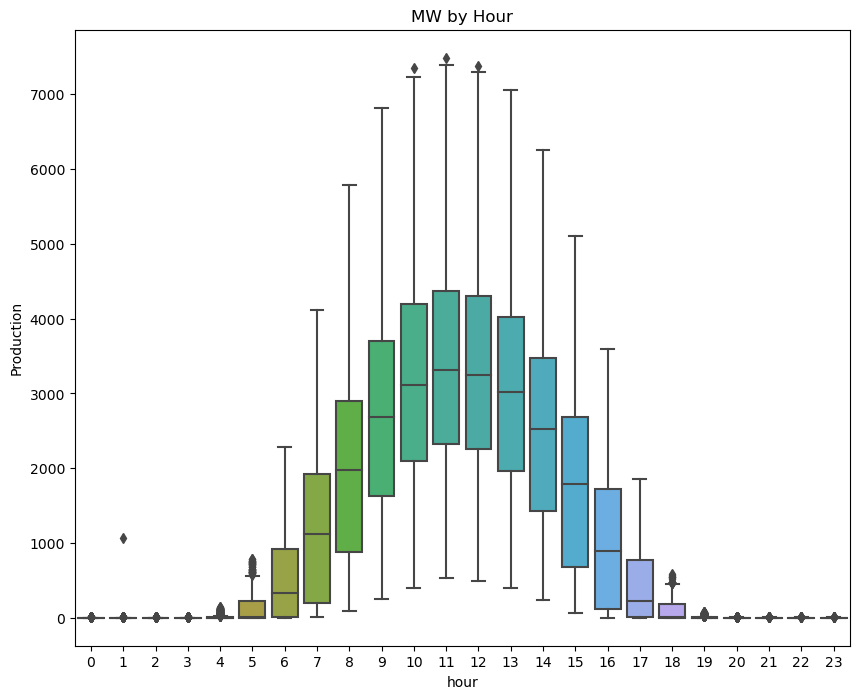

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Production')
ax.set_title('MW by Hour')
plt.show()

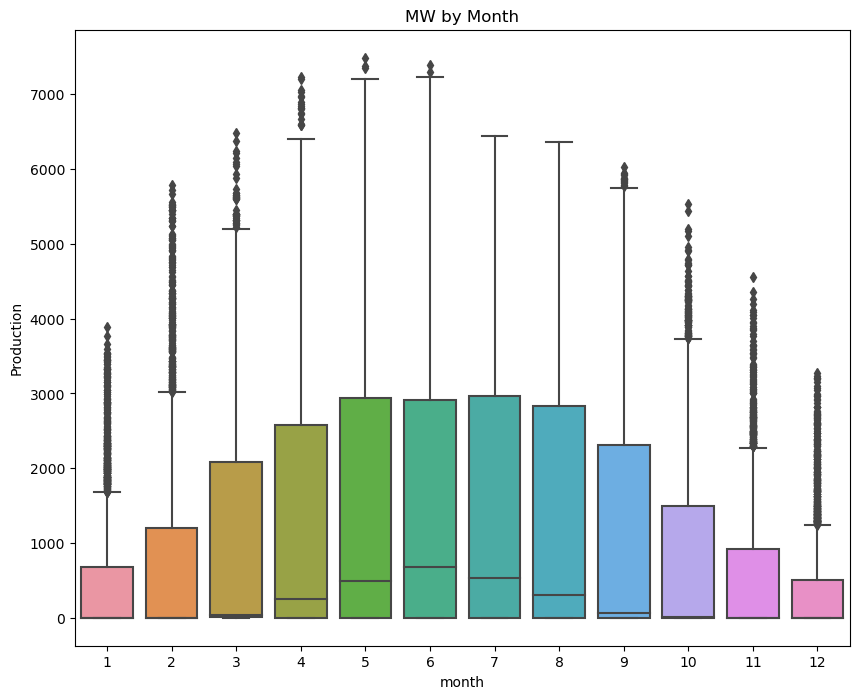

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Production')
ax.set_title('MW by Month')
plt.show()

# Criando o Modelo

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17520 entries, 0 to 40843
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date and Hour  17520 non-null  datetime64[ns]
 1   Source         17520 non-null  object        
 2   Production     17520 non-null  float64       
 3   dayOfYear      17520 non-null  int64         
 4   dayName        17520 non-null  object        
 5   monthName      17520 non-null  object        
 6   TimeZone       17520 non-null  int64         
 7   hour           17520 non-null  int64         
 8   dayofweek      17520 non-null  int64         
 9   quarter        17520 non-null  int64         
 10  month          17520 non-null  int64         
 11  year           17520 non-null  int64         
 12  dayofyear      17520 non-null  int64         
 13  dayofmonth     17520 non-null  int64         
 14  weekofyear     17520 non-null  UInt32        
dtypes: UInt32(1), datet

In [22]:
df.columns

Index(['Date and Hour', 'Source', 'Production', 'dayOfYear', 'dayName',
       'monthName', 'TimeZone', 'hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [23]:
Features = ['dayOfYear',
        'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear','TimeZone']

Target = 'Production'

In [24]:
X_train = train[Features]
y_train = train[Target]

X_test = test[Features]
y_test = test[Target]

In [25]:
reg = xgb.XGBRegressor(n_estimators = 1000,
                       learning_rate=0.01,
                       early_stopping_rounds=50
                      )
reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose=True
       )

[0]	validation_0-rmse:1300.94563	validation_1-rmse:1960.11284
[1]	validation_0-rmse:1289.72897	validation_1-rmse:1947.35350
[2]	validation_0-rmse:1278.63968	validation_1-rmse:1934.75747
[3]	validation_0-rmse:1267.67567	validation_1-rmse:1922.50528
[4]	validation_0-rmse:1256.83600	validation_1-rmse:1910.20984
[5]	validation_0-rmse:1246.11952	validation_1-rmse:1898.22612
[6]	validation_0-rmse:1235.52491	validation_1-rmse:1886.23519
[7]	validation_0-rmse:1225.05118	validation_1-rmse:1874.52423
[8]	validation_0-rmse:1214.69609	validation_1-rmse:1862.87964
[9]	validation_0-rmse:1204.45897	validation_1-rmse:1851.31252
[10]	validation_0-rmse:1194.33880	validation_1-rmse:1839.99690
[11]	validation_0-rmse:1184.33453	validation_1-rmse:1828.74474
[12]	validation_0-rmse:1174.44587	validation_1-rmse:1817.59518
[13]	validation_0-rmse:1164.67075	validation_1-rmse:1806.65878
[14]	validation_0-rmse:1155.05332	validation_1-rmse:1795.83472
[15]	validation_0-rmse:1145.54764	validation_1-rmse:1785.20188
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
reg.predict(X_test)

array([  44.73626, 2314.062  , 5101.6313 , ..., 4812.103  , 3834.8333 ,
       1970.5251 ], dtype=float32)

In [27]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importance'])

In [28]:
fi

,Importance
dayOfYear,0.029037
hour,0.377808
dayofweek,0.006434
quarter,0.001134
month,0.032448
year,0.049685
dayofyear,0.010108
dayofmonth,0.012735
weekofyear,0.064878
TimeZone,0.415734


<Axes: title={'center': 'Feature Importance'}>

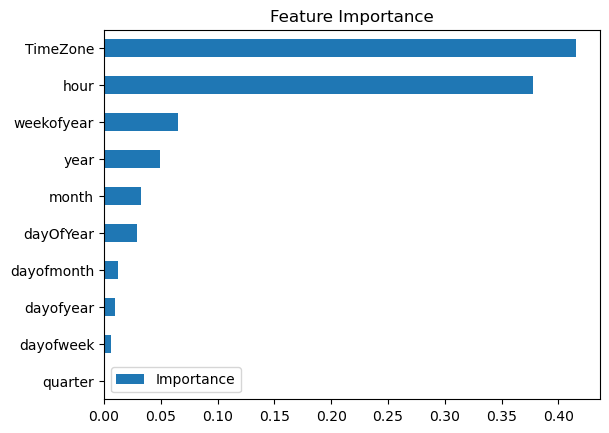

In [29]:
fi.sort_values('Importance').plot(kind='barh',title='Feature Importance')

## Forecast on Test

In [30]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

/tmp/ipykernel_24305/3715342944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


Text(0.5, 1.0, 'Production vs Prediction')

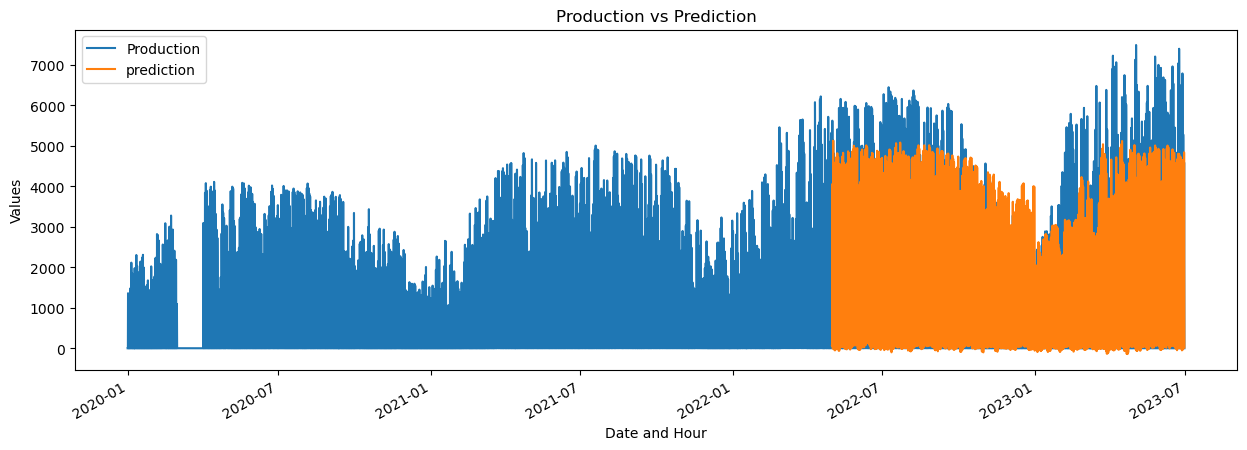

In [43]:
# Set 'Date and Hour' as the DataFrame index
df.set_index('Date and Hour', inplace=True)

# Plot 'Production' and 'prediction' columns against 'Date and Hour'
ax = df[['Production', 'prediction']].plot(figsize=(15,5))
ax.set_xlabel('Date and Hour')
ax.set_ylabel('Values')
ax.set_title('Production vs Prediction')


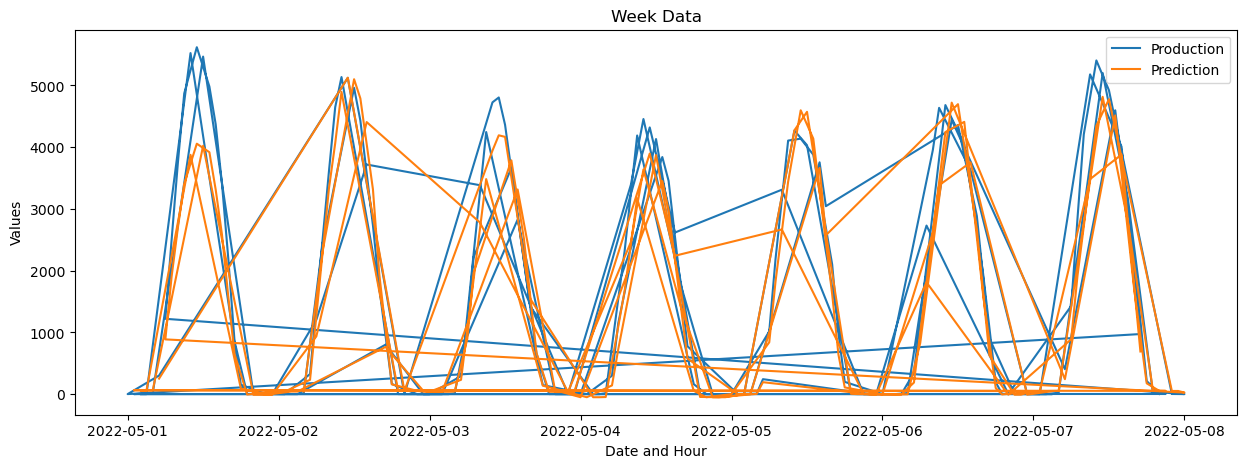

In [45]:
filtered_df = df.loc[(df.index >= '2022-05-01') & (df.index <= '2022-05-08')]

plt.figure(figsize=(15, 5))
plt.plot(filtered_df.index, filtered_df['Production'], label='Production')
plt.plot(filtered_df.index, filtered_df['prediction'], label='Prediction')
plt.title('Week Data')
plt.xlabel('Date and Hour')
plt.ylabel('Values')
plt.legend()
plt.show()

In [41]:
score = np.sqrt(mean_squared_error(test['Production'],test['prediction']))
print(f'RMSE test: {score:.2f}')

RMSE test: 730.28


In [ ]:
## Next steps
#More robust cross validation
#add more features